In [1]:
import tensorflow as tf
from prepare_dataset import create_dataset_from_tfrecord

## Load Dataset

In [2]:
# create (image, label) dataset from generator
train_ds = create_dataset_from_tfrecord('dataset/qq_captcha_train.tfrecords', batch_size=128, image_size=(60, 120), label_prefix='A').cache()
test_ds = create_dataset_from_tfrecord('dataset/qq_captcha_test.tfrecords', batch_size=128, image_size=(60, 120), label_prefix='A').cache()

## Create Model

In [3]:
def CNN_multi_outputs(image_shape, n_labels=4, n_class=26, name='captcha', output_label='labels'):
    # input
    image_input = tf.keras.Input(shape=image_shape, name='input_image')

    # conv layer 1
    x = tf.keras.layers.Conv2D(16, (3, 3))(image_input)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)

    # conv layer 2
    x = tf.keras.layers.Conv2D(32, (3, 3))(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # conv layer 3
    x = tf.keras.layers.Conv2D(64, (3, 3))(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    
    # conv layer 4
    x = tf.keras.layers.Conv2D(64, (3, 3))(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # dense layer
    x = tf.keras.layers.Flatten()(x) # flatten

    # outputs
    labels = [tf.keras.layers.Dense(n_class, name=f'{output_label}{i}')(x) for i in range(n_labels)] 

    # build model
    model = tf.keras.Model(inputs=image_input, outputs=labels, name=name)
    
    return model

In [4]:
image_shape = (60, 120, 1)
n_labels = 4
n_class = 26

model = CNN_multi_outputs(image_shape, n_labels, n_class, name='cnn_multi_outputs', output_label='A')
model.summary()

Model: "cnn_multi_outputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 60, 120, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 58, 118, 16)  160         input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 29, 59, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 27, 57, 32)   4640        max_pooling2d[0][0]              
__________________________________________________________________________________

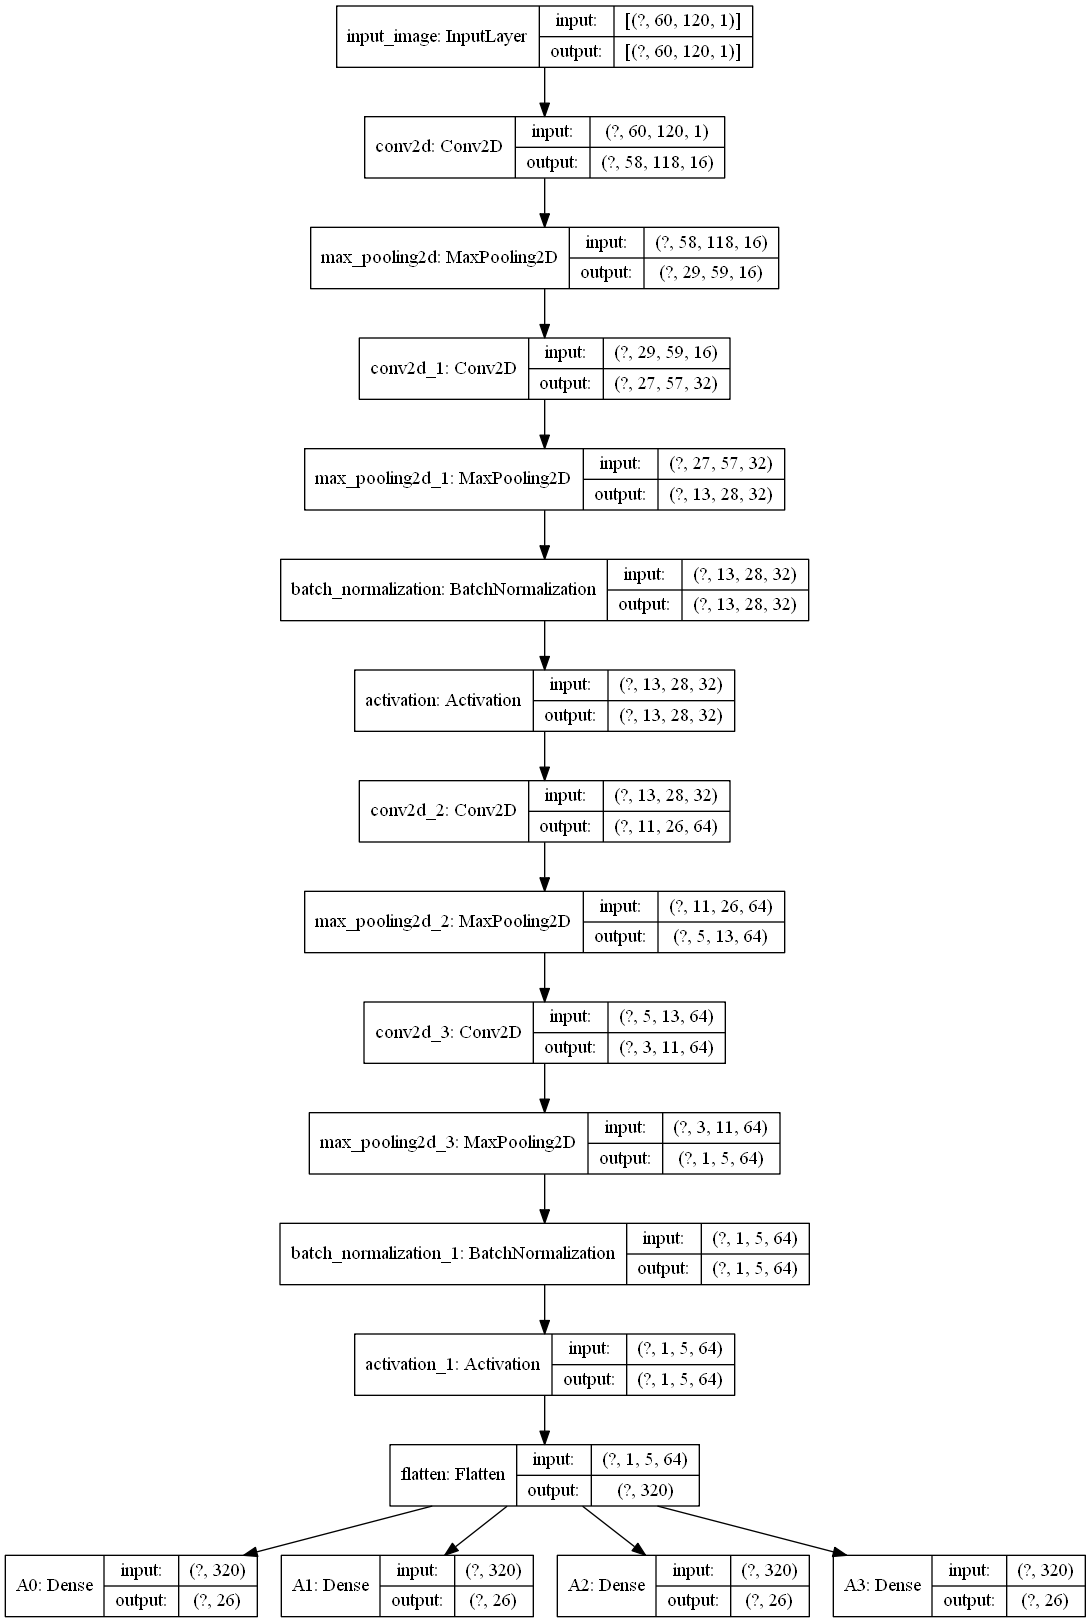

In [5]:
tf.keras.utils.plot_model(model, f'{model.name}.png', show_shapes=True)

## Train Model

In [6]:
# set loss for each output lables, or set a same loss for all labels
# e.g. loss={ f'labels_{i}': 
#   tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for i in range(n_labels)}
model.compile(optimizer="adam", #tf.keras.optimizers.RMSprop(0.001, 0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
import os

# load model if exists
model_dir = os.path.join('models', model.name) # saved in folder with same name
if os.path.exists(model_dir):
    model = tf.keras.models.load_model(model_dir)

model.fit(train_ds, 
          epochs=100, 
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir=os.path.join('tensorboard'))])

Epoch 1/100
708/708 [==============================] - 195s 275ms/step - loss: 11.3678 - A0_loss: 2.7659 - A1_loss: 2.8625 - A2_loss: 2.8978 - A3_loss: 2.8416 - A0_accuracy: 0.1889 - A1_accuracy: 0.1584 - A2_accuracy: 0.1482 - A3_accuracy: 0.1660
Epoch 2/100
708/708 [==============================] - 183s 258ms/step - loss: 7.8572 - A0_loss: 1.6288 - A1_loss: 2.1335 - A2_loss: 2.1862 - A3_loss: 1.9088 - A0_accuracy: 0.5499 - A1_accuracy: 0.3828 - A2_accuracy: 0.3644 - A3_accuracy: 0.4789
Epoch 3/100
708/708 [==============================] - 234s 330ms/step - loss: 6.1137 - A0_loss: 1.1085 - A1_loss: 1.7494 - A2_loss: 1.7949 - A3_loss: 1.4609 - A0_accuracy: 0.7034 - A1_accuracy: 0.4889 - A2_accuracy: 0.4784 - A3_accuracy: 0.6137
Epoch 4/100
708/708 [==============================] - 229s 323ms/step - loss: 5.2447 - A0_loss: 0.8941 - A1_loss: 1.5408 - A2_loss: 1.5728 - A3_loss: 1.2370 - A0_accuracy: 0.7644 - A1_accuracy: 0.5514 - A2_accuracy: 0.5473 - A3_accuracy: 0.6730
Epoch 5/100
708

525/708 [=====================>........] - ETA: 48s - loss: 3.0098 - A0_loss: 0.4421 - A1_loss: 0.8996 - A2_loss: 0.9793 - A3_loss: 0.6888 - A0_accuracy: 0.8851 - A1_accuracy: 0.7470 - A2_accuracy: 0.7291 - A3_accuracy: 0.8155

In [22]:
# save the entire model
model.save(model_dir, save_format='tf')

INFO:tensorflow:Assets written to: models\cnn_multi_outputs\assets


## Test Model

In [23]:
# load model
new_model = tf.keras.models.load_model(model_dir)

In [29]:
# evaluate model: predict four labels correctly
import numpy as np

def evaluate_captcha(model, dataset):
    '''evaluate the model with test dataset:
       the prediction is good only when the four labels are predicted correctly.
    '''
    num = 0
    scores = [0] * 5 # total, label1-4
    for images, dict_labels in dataset.as_numpy_iterator():
        outputs = model.predict(images) # list
        for (image, *zip_labels) in zip(images, *dict_labels.values(), *outputs):
            num += 1
            labels = zip_labels[0:4] # true labels
            predict_labels = [np.argmax(label) for label in zip_labels[4:]]
            # get one score when the four predictions are correct
            flag = True
            for i, (a,b) in enumerate(zip(labels, predict_labels), start=1):
                if a==b:
                    scores[i] += 1
                else:
                    flag = False
            if flag:
                scores[0] += 1
    return [score / num if num else 0 for score in scores]

In [30]:
evaluate_captcha(new_model, test_ds)

[0.15886577513620603,
 0.8088162456661714,
 0.5668647845468053,
 0.5131253095591877,
 0.6020307082714215]

predict labels: dqyb
labels        : dqlb


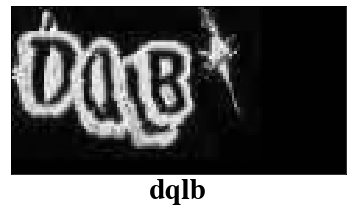

predict labels: gefg
labels        : geba


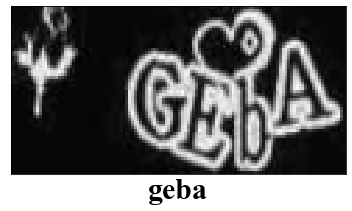

predict labels: bxmp
labels        : bykp


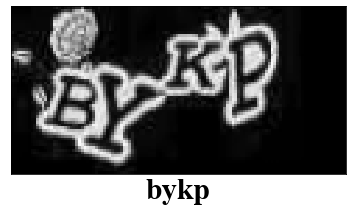

predict labels: glda
labels        : glhg


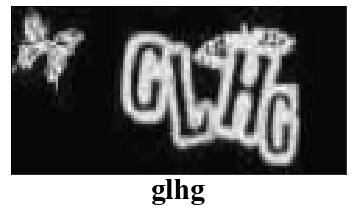

predict labels: dzdt
labels        : dzlt


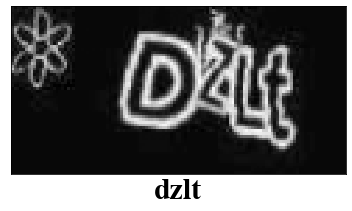

In [26]:
# prediction example
import matplotlib.pyplot as plt
%matplotlib inline

t = 50 # image t in batch

for x, y_ in test_ds.take(5):
   
    # predict labels
    y = new_model.predict(x)
    predict_labels = ''.join([chr(ord('a') + np.argmax(y[i][t])) for i in range(4)])
    print('predict labels:', predict_labels)
    
    # real labels
    labels = [y_[f'A{i}'][t].numpy()[0] for i in range(4)]
    labels = ''.join([chr(ord('a') + c) for c in labels])
    print('labels        :',labels)
    
    # show image
    image = tf.reshape(x.numpy()[t], shape=(60, 120))
    plt.imshow(image, cmap=plt.cm.binary)    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labels, fontdict={'family': 'Times New Roman', 'size' : 30})
    plt.show()